In [24]:
import pandas as pd
import numpy as np
import datetime
import glob
import matplotlib.pyplot as plt

# import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score

orig = 'train.csv'
split = 'small.csv'

In [25]:
df = pd.read_csv(split, encoding='cp1251', low_memory=False)
# df = df.dropna(axis = 0, how ='any')

In [26]:
df.head(5)

,Interval,Date,OrderDate,ClientID,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,DeliveryType,prepay,count_edit
0,18-20.,28/12/2018,27/12/2018,93405135,2,98357232430,3130259.0,35.0,HUB5,0,1.0,Обычная доставка,0,1
1,14-16.,15/08/2018,14/08/2018,92129820,2,98355988192,3058397.0,21.0,NaN,0,3.0,Обычная доставка,0,1
2,8-10.,28/06/2018,27/06/2018,93793990,2,98355661724,3108566.0,16.0,NaN,0,4.0,Обычная доставка,1,1
3,10-14.,07/12/2018,05/12/2018,93899126,2,98356948948,2013982.0,36.0,HUB5,0,1.0,Обычная доставка,0,1
4,10-14.,22/05/2018,21/05/2018,93623560,2,98355412716,3038185.0,17.0,NaN,0,1.0,Обычная доставка,0,1


In [27]:
# Удаляем лишние столбцы (почему именно эти, мы выяснили на след этапах) 
ndf = df.drop(['Cluster'], axis=1)
ndf = ndf.drop(['OrderCnt'], axis = 1)
ndf = ndf.drop(['ChannelID', 'GroupID','OrderID','MaterialID','ClientID'], axis = 1)

# Преобразуем тип доставки в значение 0 или 1
ndf['DeliveryType'] = ndf['DeliveryType'].map({'Обычная доставка': 0, 'Доставка День в День': 1})

times = ndf['Interval'].str.split('-')
ndf['time_start'] = times.apply(lambda x: int(x[0]))
# Убираем последний символ - точку из интервала
ndf['time_end'] = times.apply(lambda x: int(x[1][:-1]))
ndf = ndf.drop(['Interval'], axis = 1)
# Считаем длительность заказа
orderDate = ndf['OrderDate'].apply (lambda x: datetime.datetime.strptime (x, '%d/%m/%Y'))
date = ndf['Date'].apply (lambda x: datetime.datetime.strptime (x, '%d/%m/%Y'))
ndf['delta_day'] = (date-orderDate).dt.days.astype(int).values

# Из даты заказа вытаскиваем месяц и день недели в отдельный параметр
ndf['month'] = pd.to_datetime(ndf['OrderDate']).dt.month
ndf['day_order'] = pd.to_datetime(ndf['OrderDate']).dt.dayofweek
ndf['day_cancel'] = pd.to_datetime(ndf['Date']).dt.dayofweek
month = ndf['month']
winter = list([12, 1, 2]) 
spring = list([3, 4, 5]) 
summer = list([6, 7, 8]) 
autumn = list([9, 10, 11])
# Выделяем сезон, когда был сделан заказ
ndf['winter'] = month.isin(winter).apply(lambda x: 1 if x else 0)
ndf['spring'] = month.isin(spring).apply(lambda x: 1 if x else 0)
ndf['summer'] = month.isin(summer).apply(lambda x: 1 if x else 0)
ndf['autumn'] = month.isin(autumn).apply(lambda x: 1 if x else 0)
# Выделяем время суток
morning = list(range(6, 12))
day = list(range(12, 18))
evening = list(range(18, 24))
night = [24] + list(range(1, 6))
# Усредняем интервал времени заказа
c_time =  (ndf['time_start'] + ndf['time_end']) / 2
ndf['time'] = c_time

ndf['morning'] = c_time.isin(morning).apply(lambda x: 1 if x else 0)
ndf['day'] = c_time.isin(day).apply(lambda x: 1 if x else 0)
ndf['evening'] = c_time.isin(evening).apply(lambda x: 1 if x else 0)
ndf['night'] = c_time.isin(night).apply(lambda x: 1 if x else 0)
# Удаляем даты, т.к. мы их преобразовали
ndf = ndf.drop(['Date'], axis = 1)
ndf = ndf.drop(['OrderDate'], axis = 1)

ndf.head(20)

,CancelFlag,DeliveryType,prepay,count_edit,time_start,time_end,delta_day,month,day_order,day_cancel,winter,spring,summer,autumn,time,morning,day,evening,night
0,0,0,0,1,18,20,1,12,3,4,1,0,0,0,19.0,0,0,1,0
1,0,0,0,1,14,16,1,8,1,2,0,0,1,0,15.0,0,1,0,0
2,0,0,1,1,8,10,1,6,2,3,0,0,1,0,9.0,1,0,0,0
3,0,0,0,1,10,14,2,5,5,3,0,1,0,0,12.0,0,1,0,0
4,0,0,0,1,10,14,1,5,0,1,0,1,0,0,12.0,0,1,0,0
5,0,0,1,1,10,12,1,7,3,4,0,0,1,0,11.0,1,0,0,0
6,0,0,0,1,22,2,1,11,2,3,0,0,0,1,12.0,0,1,0,0
7,1,0,0,1,18,20,1,1,3,6,1,0,0,0,19.0,0,0,1,0
8,0,0,0,1,14,16,2,5,2,5,0,1,0,0,15.0,0,1,0,0
9,0,0,0,1,18,20,2,3,6,4,0,1,0,0,19.0,0,0,1,0


CancelFlag
0    236213
1     13787
Name: prepay, dtype: int64


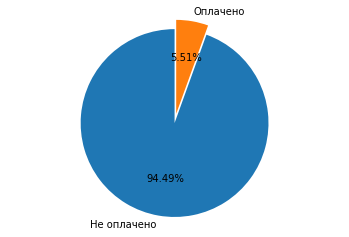

In [28]:
# Распределение оплаченных и не оплаченных заказов
tdf = ndf[['CancelFlag','prepay']].groupby('CancelFlag').count()['prepay']
print(tdf)

name = 'Не оплачено','Оплачено'
explode = (0.0, 0.1)

f, ax = plt.subplots()
ax.pie(tdf, explode=explode, labels=name, autopct='%1.2f%%', startangle=90)
ax.axis('equal')

plt.show()

DeliveryType
0    244117
1      5883
Name: CancelFlag, dtype: int64


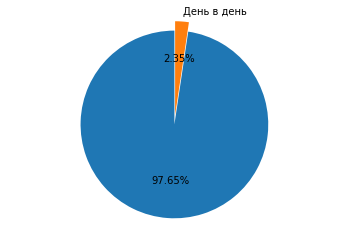

In [29]:
# Распределение типа доставок
tdf = ndf[['CancelFlag','DeliveryType']].groupby('DeliveryType').count()['CancelFlag']
print(tdf)

name = '','День в день'
explode = (0.0, 0.1)

f, ax = plt.subplots()
ax.pie(tdf, explode=explode, labels=name, autopct='%1.2f%%', startangle=90)
ax.axis('equal')

plt.show()

            morning    day  evening  night
CancelFlag                                
0             88152  84925    57070    766
1              5072   4942     3160     78
[0.05440659 0.05499238 0.05246555 0.09241706]


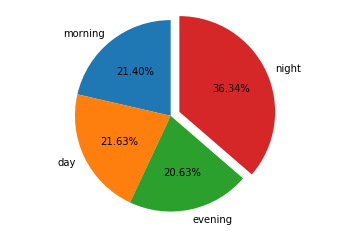

In [30]:
# Влияние времени суток на отказ от заказа
tdf = ndf[['CancelFlag','morning','day', 'evening', 'night']].groupby('CancelFlag').sum()
print(tdf)

name = 'morning', 'day', 'evening', 'night'
explode = (0.0, 0.0, 0.0, 0.1)

result = tdf.values[1]/(tdf.values[0]+tdf.values[1])
print(result)

f, ax = plt.subplots()
ax.pie(result*100, explode=explode, labels=name, autopct='%1.2f%%', startangle=90)
ax.axis('equal')

plt.show()

In [31]:
# Распределение отказа по параметрам
tdf = ndf[['CancelFlag','morning','day', 'evening', 'night', 'prepay', 'count_edit', 'DeliveryType', 'time' ]].groupby('CancelFlag').var()
print(tdf)

             morning       day   evening     night    prepay  count_edit  \
CancelFlag                                                                 
0           0.233920  0.230268  0.183232  0.003232  0.161821   17.749952   
1           0.232562  0.229981  0.176681  0.005626  0.062909   21.669595   

            DeliveryType       time  
CancelFlag                           
0               0.023307  19.044148  
1               0.017316  18.943880  


In [32]:
# tdf = ndf[['CancelFlag','winter','spring', 'summer', 'autumn', 'prepay', 'count_edit', 'DeliveryType', 'time' ]].groupby('CancelFlag').var()
# Распределение отказа по параметрам
tdf = ndf.groupby('CancelFlag').var()
print(tdf)

            DeliveryType    prepay  count_edit  time_start   time_end  \
CancelFlag                                                              
0               0.023307  0.161821   17.749952   23.397483  30.227656   
1               0.017316  0.062909   21.669595   25.857440  35.746171   

            delta_day      month  day_order  day_cancel    winter    spring  \
CancelFlag                                                                    
0            0.234126  12.731117   3.804811    3.988691  0.198312  0.191070   
1            0.443178  12.873054   3.845673    3.974557  0.201858  0.191483   

              summer    autumn       time   morning       day   evening  \
CancelFlag                                                                
0           0.171350  0.187779  19.044148  0.233920  0.230268  0.183232   
1           0.174902  0.180021  18.943880  0.232562  0.229981  0.176681   

               night  
CancelFlag            
0           0.003232  
1           0.005626

In [33]:
# Разделение датасета на тренировочный и тестовый 80 на 20 и выделение предсказываемого параметра 
# X = ndf.drop(['CancelFlag', 'morning', 'day', 'evening','night'], axis = 1)
X = ndf[['prepay','DeliveryType','delta_day', 'count_edit', 'time_start','time_end', 'month', 'day_order', 'day_cancel']]
# X = ndf.drop(['CancelFlag'], axis = 1)
y = ndf['CancelFlag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=13) 

In [36]:
# Метод ближайших соседей
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 500, weights = 'distance',algorithm = 'kd_tree')
model.fit(X_train, y_train)

print(model)

expected = y_train
predicted = model.predict(X_train)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=500, p=2,
                     weights='distance')
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    188989
           1       0.91      0.18      0.30     11011

    accuracy                           0.95    200000
   macro avg       0.93      0.59      0.64    200000
weighted avg       0.95      0.95      0.94    200000

[[188804    185]
 [  9040   1971]]


In [90]:
# Метод наивного байеса
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
print(model)
# make predictions
expected = y_train
predicted = model.predict(X_train)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

GaussianNB(priors=None, var_smoothing=1e-09)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     70421
           1       0.14      0.02      0.04      3944

    accuracy                           0.94     74365
   macro avg       0.54      0.51      0.51     74365
weighted avg       0.90      0.94      0.92     74365

[[69833   588]
 [ 3849    95]]


In [34]:
# Метод случайного леса
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500, 
                               max_depth = 25,
                               criterion='entropy',
                               bootstrap = True,
                               max_features = 'sqrt')
model.fit(X_train, y_train)
print(model)
# make predictions
expected = y_train
predicted = model.predict(X_train)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=25, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    188989
           1       0.90      0.18      0.30     11011

    accuracy                           0.95    200000
   macro avg       0.93      0.59      0.64    200000
weighted avg       0.95      0.95      0.94    200000

[[188762    227]
 [  9000   2011]]


In [49]:
model.score(X_train, y_train)

0.9446917232569085

In [50]:
model.score(X_test,y_test)

0.9432013769363167

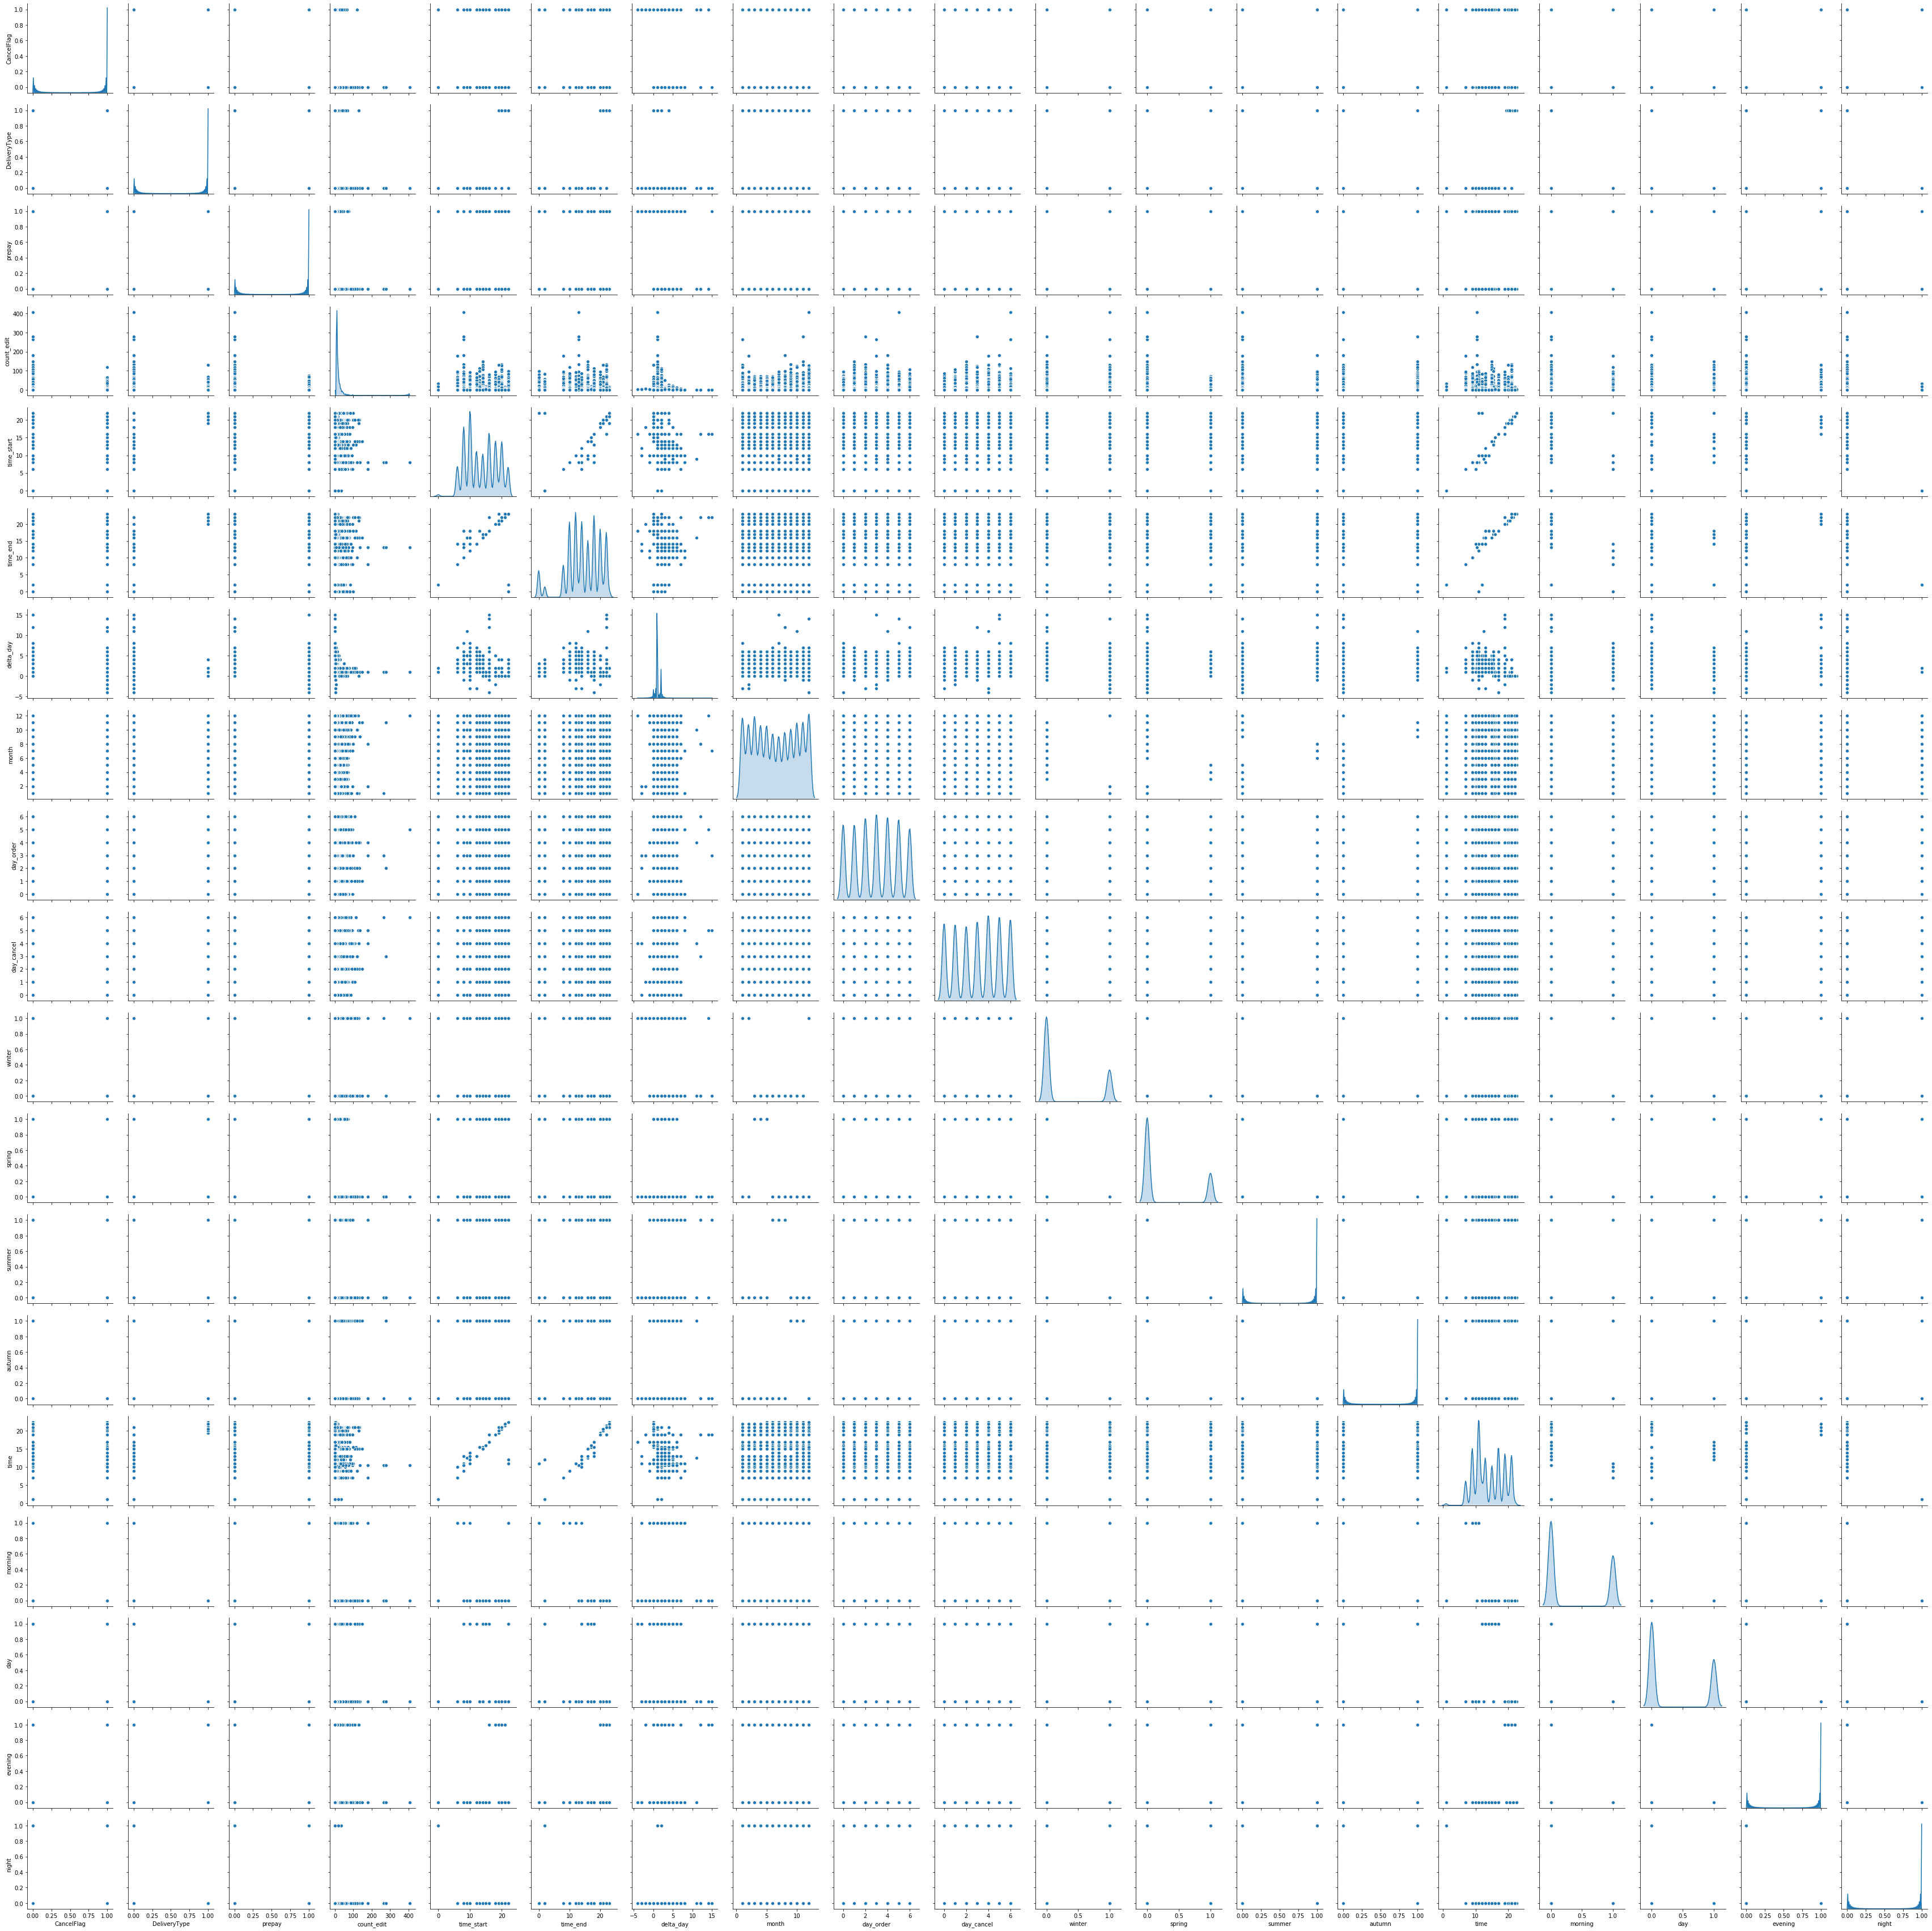

In [14]:
import seaborn as sns

# Эта ужасная фигня которая считалась очень долго, а толку от нее почти нет
sns.pairplot(ndf, diag_kind="kde")

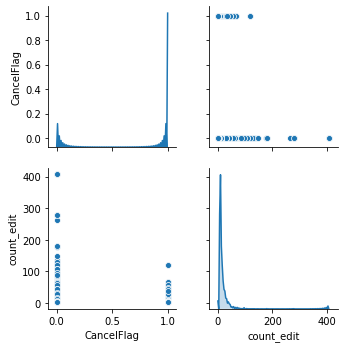

In [20]:
sns.pairplot(ndf[['CancelFlag','count_edit']], diag_kind="kde")

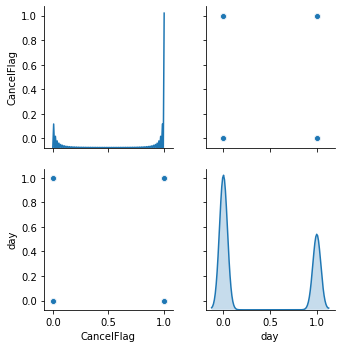

In [22]:
sns.pairplot(ndf[['CancelFlag','day']], diag_kind="kde")

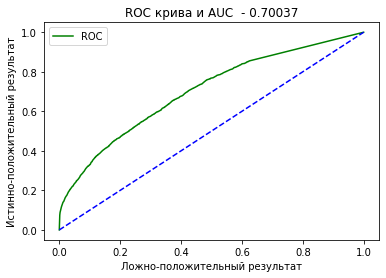

In [37]:
# Построение ROC кривой и AUC 
# def plot_roc_curve(fpr, tpr, n, current_score):
#     plt.plot(fpr, tpr, color='green', label='ROC')
#     plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
#     plt.xlabel('Ложно-положительный результат')
#     plt.ylabel('Истинно-положительный результат')
#     plt.title('ROC крива и AUC  - %.5f' % current_score)
#     plt.legend()
#     plt.show()
#     plt.close()

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
# plot_roc_curve(fpr, tpr, "", auc)

plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('Ложно-положительный результат')
plt.ylabel('Истинно-положительный результат')
plt.title('ROC кривая и AUC  - %.5f' % auc)
plt.legend()
plt.show()
plt.close()